In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from functools import partial, reduce
from sqlalchemy import create_engine
import datetime
from sqlite3 import connect

In [2]:
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [210703, 210710, 210717, 210724, 210731, 210807, 210814, 210821, 210828, 210904, 210911, 210918, 210925]
turnstiles_df = get_data(week_nums)
turnstiles_df.to_csv("D:\\data.csv", index=False)

In [3]:
engine=create_engine("sqlite://", echo=False)
turnstiles_df.to_sql('data', con=engine)

In [4]:
df=pd.read_sql('SELECT * FROM data group by STATION order by ENTRIES limit 10 ', engine)
df

,index,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,126048,PTH17,R541,01-00-00,THIRTY THIRD ST,1,PTH,06/26/2021,00:20:16,REGULAR,0,0
1,72699,N181A,R464,00-05-00,AQUEDUCT RACETR,A,IND,06/26/2021,00:00:00,REGULAR,14,236
2,46863,N012,R035,01-05-00,168 ST,AC1,IND,06/26/2021,00:00:00,REGULAR,27,0
3,160448,R235,R045,01-00-00,GRD CNTRL-42 ST,4567S,IRT,06/26/2021,01:00:00,REGULAR,82,662
4,132107,R106,R305,01-00-00,WTC-CORTLANDT,1,IRT,06/26/2021,01:00:00,REGULAR,144,138
5,45148,N001,R173,01-05-00,INWOOD-207 ST,A,IND,06/26/2021,01:00:00,REGULAR,590,0
6,109804,N547,R420,01-04-00,DITMAS AV,F,IND,06/26/2021,01:00:00,REGULAR,872,0
7,17524,B023,R211,01-05-00,KINGS HWY,BQ,BMT,06/26/2021,00:00:00,REGULAR,888,0
8,91678,N338,R128,01-05-00,SUTPHIN BLVD,F,IND,06/26/2021,05:00:00,REGULAR,1762,0
9,92090,N339,R114,01-05-00,PARSONS BLVD,F,IND,06/26/2021,00:00:00,REGULAR,2023,0


In [6]:
turnstiles_df.columns = [column.strip() for column in turnstiles_df.columns]
turnstiles_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [7]:
turnstiles_df=turnstiles_df[["C/A","STATION","DATE","TIME","ENTRIES",'EXITS']]

In [8]:
turnstiles_df.head()

,C/A,STATION,DATE,TIME,ENTRIES,EXITS
0,A002,59 ST,06/26/2021,00:00:00,7592792,2595706
1,A002,59 ST,06/26/2021,04:00:00,7592804,2595713
2,A002,59 ST,06/26/2021,08:00:00,7592816,2595729
3,A002,59 ST,06/26/2021,12:00:00,7592870,2595762
4,A002,59 ST,06/26/2021,16:00:00,7592992,2595791


In [9]:
turnstiles_df.columns

Index(['C/A', 'STATION', 'DATE', 'TIME', 'ENTRIES', 'EXITS'], dtype='object')

In [10]:
turnstiles_df.describe()

,ENTRIES,EXITS
count,2.724418e+06,2.724418e+06
mean,4.148078e+07,3.317211e+07
std,2.181339e+08,1.916161e+08
min,0.000000e+00,0.000000e+00
25%,2.198380e+05,1.027980e+05
50%,1.396824e+06,8.526620e+05
75%,5.997710e+06,3.971601e+06
max,2.147407e+09,2.133797e+09


In [12]:
print('Number of instances = %d' % (turnstiles_df.shape[0])) #row
print('Number of attributes = %d' % (turnstiles_df.shape[1])) #column

Number of instances = 2724418
Number of attributes = 6


In [13]:
cols_data = pd.DataFrame(turnstiles_df.dtypes)
num_cols = list(cols_data[cols_data[0]=='int64'].index)
cat_cols = list(cols_data[cols_data[0]=='object'].index)
print('Numeric variables includes:','\n',num_cols)
print('\nCategorical variables includes','\n',cat_cols)

Numeric variables includes: 
 ['ENTRIES', 'EXITS']

Categorical variables includes 
 ['C/A', 'STATION', 'DATE', 'TIME']


# Data Cleaning

In [14]:
turnstiles_df.isna()

,C/A,STATION,DATE,TIME,ENTRIES,EXITS
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False
...,...,...,...,...,...,...
210395,False,False,False,False,False,False
210396,False,False,False,False,False,False
210397,False,False,False,False,False,False
210398,False,False,False,False,False,False


In [16]:
turnstiles_df.isna().sum()

C/A        0
STATION    0
DATE       0
TIME       0
ENTRIES    0
EXITS      0
dtype: int64

# Duplicate Data

In [17]:
dups = turnstiles_df.duplicated().sum()
print('\nNumber of duplicate rows = %d' % (dups))
print('\nNumber of rows before discarding duplicates = %d' % (turnstiles_df.shape[0]))
turnstiles_df2= turnstiles_df.drop_duplicates()
print('Number of rows after discarding duplicates = %d' % (turnstiles_df2.shape[0])) 


Number of duplicate rows = 10

Number of rows before discarding duplicates = 2724418
Number of rows after discarding duplicates = 2724408


In [18]:
for i,v in enumerate(cat_cols):
    turnstiles_df2[v].str.strip()

In [19]:
i=turnstiles_df2[(turnstiles_df2['ENTRIES']==0) | (turnstiles_df2['EXITS']==0)].index
turnstiles_df3=turnstiles_df2.drop(i)

# Outlier

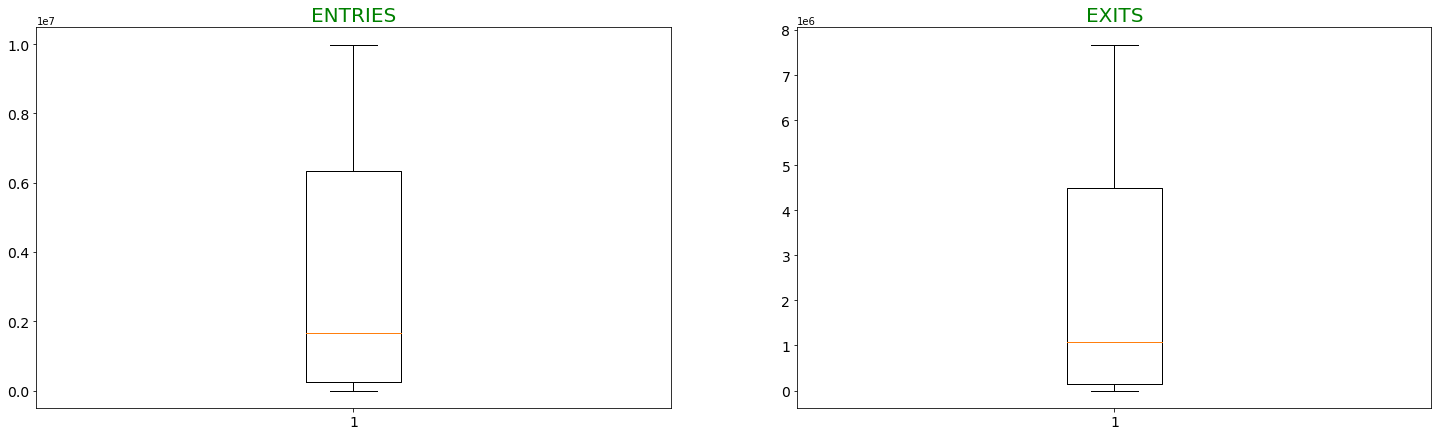

<ipython-input-21-5b9f580f67a0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  turnstiles_df3['ENTRIES']= winsorize(turnstiles_df3['ENTRIES'],(0,0.15))
<ipython-input-21-5b9f580f67a0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  turnstiles_df3['EXITS'] = winsorize(turnstiles_df3['EXITS'],(0,0.15))


In [21]:
num_feat = turnstiles_df3.select_dtypes(include=['int64']).columns
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.boxplot(turnstiles_df3[num_feat[i]])
    plt.title(num_feat[i],color="g",fontsize=20)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)

plt.show()  
turnstiles_df3['ENTRIES']= winsorize(turnstiles_df3['ENTRIES'],(0,0.15))
turnstiles_df3['EXITS'] = winsorize(turnstiles_df3['EXITS'],(0,0.15))
plt.rcParams['figure.figsize'] = (25,7)
baslik_font = {'family':'arial','color':'purple','weight':'bold','size':25}
col_list=['ENTRIES', 'EXITS']

# Aggregation

In [22]:
turnstiles_df3["DATE_TIME"] = pd.to_datetime(turnstiles_df3.DATE + " " + turnstiles_df3.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")
turnstiles_df3['MONTH'] = turnstiles_df3['DATE_TIME'].dt.month

<ipython-input-22-c4fa77f75e49>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  turnstiles_df3["DATE_TIME"] = pd.to_datetime(turnstiles_df3.DATE + " " + turnstiles_df3.TIME,
<ipython-input-22-c4fa77f75e49>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  turnstiles_df3['MONTH'] = turnstiles_df3['DATE_TIME'].dt.month


In [23]:
turnstiles_df3['DAY_WEEK'] = turnstiles_df3[['DATE_TIME']]\
    .apply(lambda x: datetime.datetime.strftime(x['DATE_TIME'], '%A'), axis=1)

<ipython-input-23-dbf1fc6886b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  turnstiles_df3['DAY_WEEK'] = turnstiles_df3[['DATE_TIME']]\


In [24]:
turnstiles_df3['Entry_Inc'] = abs(turnstiles_df3.ENTRIES.diff())
turnstiles_df3['Exits_Inc'] = abs(turnstiles_df3.EXITS.diff())
turnstiles_df3['TOTAL_TRAFFIC'] = np.add(turnstiles_df3.Entry_Inc, turnstiles_df3.Exits_Inc)

<ipython-input-24-45c9971b3e46>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  turnstiles_df3['Entry_Inc'] = abs(turnstiles_df3.ENTRIES.diff())
<ipython-input-24-45c9971b3e46>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  turnstiles_df3['Exits_Inc'] = abs(turnstiles_df3.EXITS.diff())
<ipython-input-24-45c9971b3e46>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [25]:
# filter outliers above specified quantile
quant_filt = 0.99
q = turnstiles_df3["Entry_Inc"].quantile(quant_filt)
turnstiles_df3 = turnstiles_df3[turnstiles_df3["Entry_Inc"] < q]

r = turnstiles_df3["Exits_Inc"].quantile(quant_filt)
turnstiles_df3 = turnstiles_df3[turnstiles_df3["Exits_Inc"] < r]

s = turnstiles_df3["TOTAL_TRAFFIC"].quantile(quant_filt)
turnstiles_df3 = turnstiles_df3[turnstiles_df3["TOTAL_TRAFFIC"] < s]

turnstiles_df3 = turnstiles_df3.dropna() # apparently no issues with NaN cells; running as best practice

turnstiles_df3.head()

,C/A,STATION,DATE,TIME,ENTRIES,EXITS,DATE_TIME,MONTH,DAY_WEEK,Entry_Inc,Exits_Inc,TOTAL_TRAFFIC
1,A002,59 ST,06/26/2021,04:00:00,7592804,2595713,2021-06-26 04:00:00,6,Saturday,12.0,7.0,19.0
2,A002,59 ST,06/26/2021,08:00:00,7592816,2595729,2021-06-26 08:00:00,6,Saturday,12.0,16.0,28.0
3,A002,59 ST,06/26/2021,12:00:00,7592870,2595762,2021-06-26 12:00:00,6,Saturday,54.0,33.0,87.0
4,A002,59 ST,06/26/2021,16:00:00,7592992,2595791,2021-06-26 16:00:00,6,Saturday,122.0,29.0,151.0
5,A002,59 ST,06/26/2021,20:00:00,7593116,2595809,2021-06-26 20:00:00,6,Saturday,124.0,18.0,142.0


In [26]:
sample=turnstiles_df3.loc[turnstiles_df3.MONTH==9]
sample

,C/A,STATION,DATE,TIME,ENTRIES,EXITS,DATE_TIME,MONTH,DAY_WEEK,Entry_Inc,Exits_Inc,TOTAL_TRAFFIC
24,A002,59 ST,09/01/2021,00:00:00,7628030,2609899,2021-09-01 00:00:00,9,Wednesday,83.0,21.0,104.0
25,A002,59 ST,09/01/2021,04:00:00,7628037,2609904,2021-09-01 04:00:00,9,Wednesday,7.0,5.0,12.0
26,A002,59 ST,09/01/2021,08:00:00,7628051,2609949,2021-09-01 08:00:00,9,Wednesday,14.0,45.0,59.0
27,A002,59 ST,09/01/2021,12:00:00,7628112,2610083,2021-09-01 12:00:00,9,Wednesday,61.0,134.0,195.0
28,A002,59 ST,09/01/2021,16:00:00,7628256,2610111,2021-09-01 16:00:00,9,Wednesday,144.0,28.0,172.0
...,...,...,...,...,...,...,...,...,...,...,...,...
210395,TRAM2,RIT-ROOSEVELT,09/24/2021,05:00:00,5554,645,2021-09-24 05:00:00,9,Friday,0.0,0.0,0.0
210396,TRAM2,RIT-ROOSEVELT,09/24/2021,09:00:00,5554,645,2021-09-24 09:00:00,9,Friday,0.0,0.0,0.0
210397,TRAM2,RIT-ROOSEVELT,09/24/2021,13:00:00,5554,645,2021-09-24 13:00:00,9,Friday,0.0,0.0,0.0
210398,TRAM2,RIT-ROOSEVELT,09/24/2021,17:00:00,5554,646,2021-09-24 17:00:00,9,Friday,0.0,1.0,1.0


# Visualiztion

In [27]:
df1=sample.groupby(['STATION'])['TOTAL_TRAFFIC'].sum().sort_values(ascending=False).reset_index().head(10)
df1

,STATION,TOTAL_TRAFFIC
0,34 ST-PENN STA,1337480.0
1,GRD CNTRL-42 ST,1261595.0
2,14 ST-UNION SQ,1086681.0
3,TIMES SQ-42 ST,1083166.0
4,34 ST-HERALD SQ,1076300.0
5,23 ST,952499.0
6,59 ST,918036.0
7,PATH NEW WTC,896206.0
8,86 ST,848045.0
9,FULTON ST,819435.0


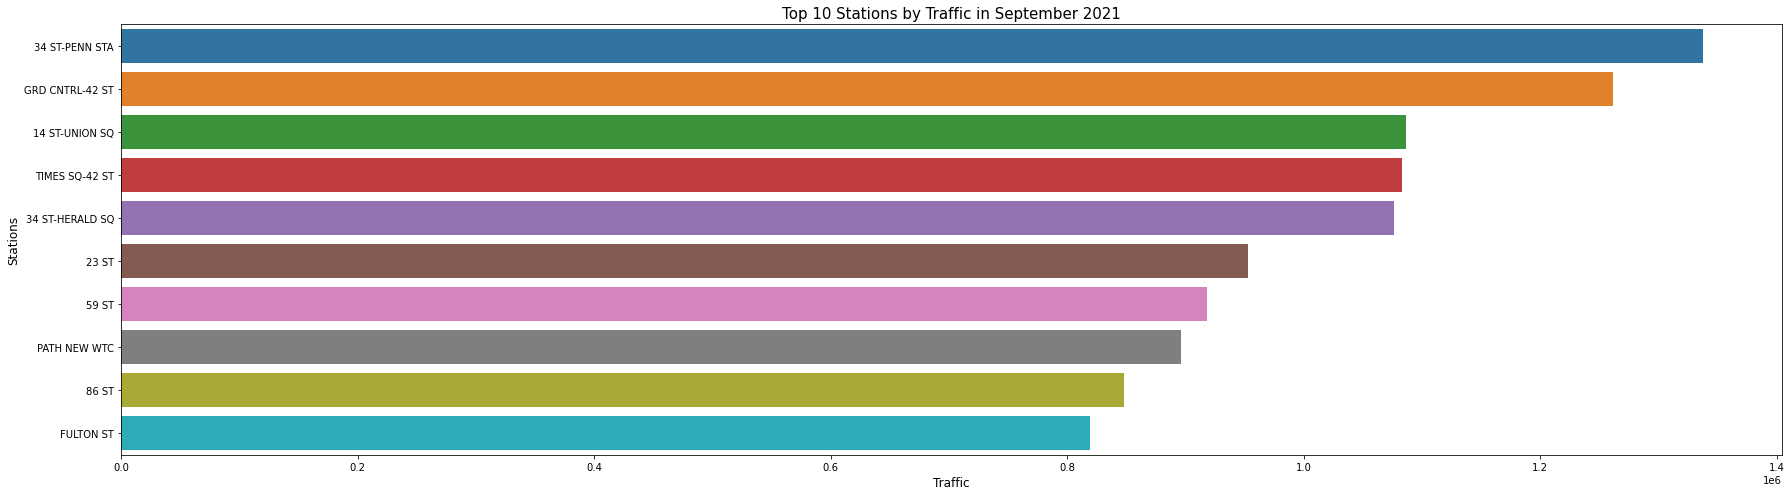

In [28]:
ax = sns.barplot(x="TOTAL_TRAFFIC", y='STATION', data=df1)

plt.xlabel('Traffic', fontsize=12)
plt.ylabel('Stations', fontsize=12)
plt.title("Top 10 Stations by Traffic in September 2021", fontsize=15)
plt.tight_layout()
plt.show()

In [29]:
df2=sample.groupby(['DAY_WEEK'])['TOTAL_TRAFFIC'].sum().sort_values(ascending=False).reset_index()
df2

,DAY_WEEK,TOTAL_TRAFFIC
0,Wednesday,9957872.0
1,Friday,9955762.0
2,Thursday,9044201.0
3,Tuesday,7582595.0
4,Monday,6559748.0
5,Saturday,4550506.0
6,Sunday,4462230.0


Text(0.5, 1.0, 'Day of Week by Traffic in September 2021')

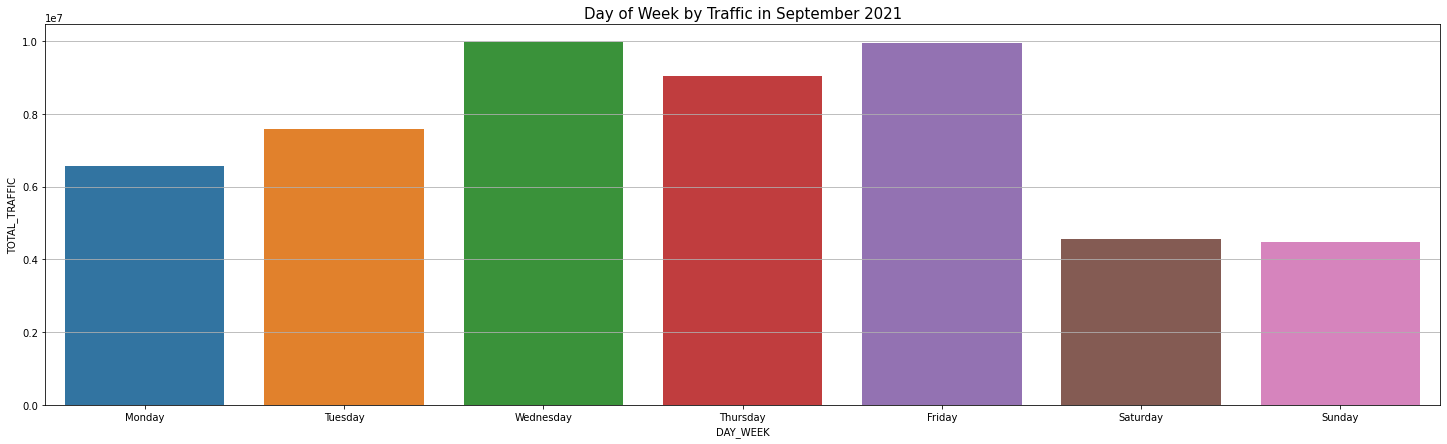

In [31]:
plt.grid()
sns.barplot(x = 'DAY_WEEK',y='TOTAL_TRAFFIC',data=df2,order=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
plt.title("Day of Week by Traffic in September 2021", fontsize=15)

In [32]:
mta_time=turnstiles_df3[turnstiles_df3["STATION"]=="34 ST-PENN STA"]
stations_day_time = mta_time[['STATION', 'TIME', 'DAY_WEEK','TOTAL_TRAFFIC']]
stations_day_time_group = stations_day_time.groupby(['STATION','DAY_WEEK','TIME'], as_index=False)
stations_day_time_group = stations_day_time_group[['TOTAL_TRAFFIC']].sum()
stations_day_time_group['TIME'] = pd.to_datetime(stations_day_time_group['TIME'], format='%H:%M:%S')
rounded_day_time = stations_day_time_group.set_index('TIME').groupby(['STATION','DAY_WEEK'])
rounded_day_time = rounded_day_time.resample("4H").sum()
rounded_day_time = rounded_day_time.reset_index()
rounded_day_time.head()

,STATION,DAY_WEEK,TIME,TOTAL_TRAFFIC
0,34 ST-PENN STA,Friday,1900-01-01 00:00:00,66168.0
1,34 ST-PENN STA,Friday,1900-01-01 04:00:00,17487.0
2,34 ST-PENN STA,Friday,1900-01-01 08:00:00,132032.0
3,34 ST-PENN STA,Friday,1900-01-01 12:00:00,160935.0
4,34 ST-PENN STA,Friday,1900-01-01 16:00:00,218162.0


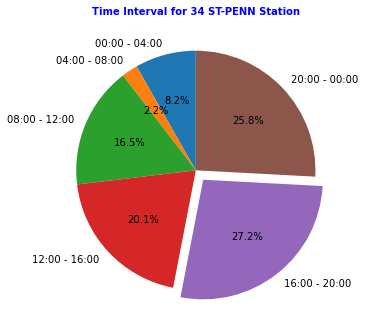

In [33]:
plt.style.use('seaborn-notebook')
fig1, ax1 = plt.subplots()
time = '00:00 - 04:00', '04:00 - 08:00', '08:00 - 12:00', '12:00 - 16:00','16:00 - 20:00','20:00 - 00:00'
traffic = rounded_day_time["TOTAL_TRAFFIC"].head(6)
explode = (0, 0, 0, 0 ,0.1 ,0)  
ax1.pie(traffic, explode=explode, labels=time, autopct='%1.1f%%', startangle=90)
plt.title("Time Interval for 34 ST-PENN Station", weight="bold", c="b", fontsize=10)
plt.show()

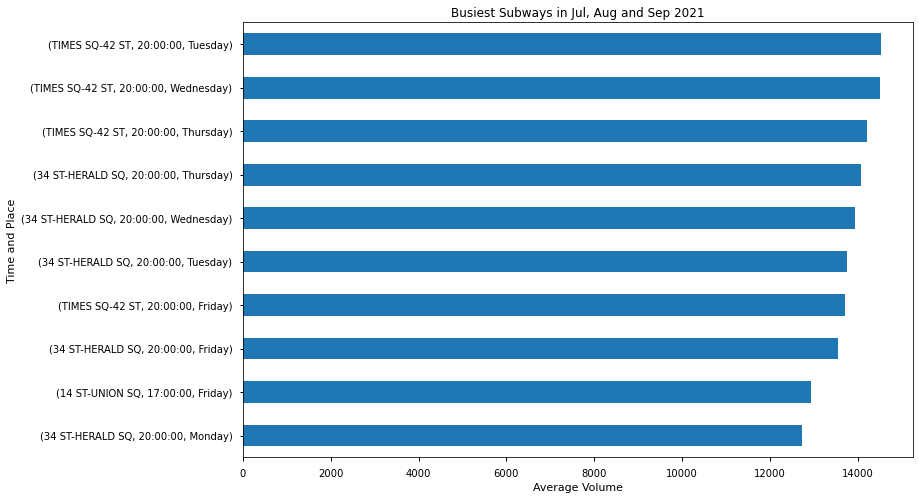

In [34]:
def recommendation_chart(df):
    df_pre = df[['STATION', 'DATE_TIME', 'TOTAL_TRAFFIC', 'DAY_WEEK', 'TIME']].copy()
    
    df1 = df_pre.groupby(['STATION','DATE_TIME','TIME','DAY_WEEK'])\
    .sum()\
    .reset_index()\
    .groupby(['STATION', 'TIME', 'DAY_WEEK'])\
    .mean()\
    .sort_values(by='TOTAL_TRAFFIC', ascending=False)
    
    fig, ax = plt.subplots(figsize=(12,8))
    df1[:10]['TOTAL_TRAFFIC'].sort_values(ascending=True).plot(kind='barh', ax=ax)
    ax.set_xlabel('Average Volume')
    ax.set_ylabel('Time and Place')
    ax.set_title('Busiest Subways in Jul, Aug and Sep 2021')
    
recommendation_chart(turnstiles_df3)